In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import csv

from matplotlib.pyplot import cm
#from scipy.signal import find_peaks
from scipy import signal

In [2]:
# Set the style of the plots to a more beautiful format
az.style.use('arviz-whitegrid')

In [3]:
EEE = []
for nu in np.arange(0.0298,0.0305,0.000005):
    L = 2 * np.pi
    nx = 4096

    t0 = 0 
    tN = 7
    dt = 0.001
    nt = int((tN - t0) / dt)

    # wave number mesh
    k = np.arange(-nx/2, nx/2, 1)

    t = np.linspace(start=t0, stop=tN, num=nt)
    x = np.linspace(start=0, stop=L, num=nx)

    # solution mesh in real space
    u = np.ones((nx, nt))
    # solution mesh in Fourier space
    u_hat = np.ones((nx, nt), dtype=complex)

    u_hat2 = np.ones((nx, nt), dtype=complex)

    # initial condition 
    #u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)
    u0 = - np.sin(x)

    # Fourier transform of initial condition
    u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))

    u0_hat2 = (1 / nx) * np.fft.fftshift(np.fft.fft(u0**2))

    # set initial condition in real and Fourier mesh
    u[:,0] = u0
    u_hat[:,0] = u0_hat

    u_hat2[:,0] = u0_hat2

    # Fourier Transform of the linear operator
    FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4
    # Fourier Transform of the non-linear operator
    FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)

    # resolve EDP in Fourier space
    for j in range(0,nt-1):
        uhat_current = u_hat[:,j]
        uhat_current2 = u_hat2[:,j]
        if j == 0:
            uhat_last = u_hat[:,0]
            uhat_last2 = u_hat2[:,0]
        else:
            uhat_last = u_hat[:,j-1]
            uhat_last2 = u_hat2[:,j-1]

        # compute solution in Fourier space through a finite difference method
        # Cranck-Nicholson + Adam 
        u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current2) - ((1 / 2) * FN) * (uhat_last2) ) * dt )
        # go back in real space
        u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))
        u_hat2[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]**2))


    dx = L / nx
    E = []
    Ederiv = [0]

    for j in range(0,nt):
        E.append(np.sqrt(sum(u[:,j]**2 * dx)))

    #E = [100-element for element in E]
        
    #Ederiv[0]= E[0]
    #for j in range(1,nt-1):
    #    Ederiv.append((E[j+1]-E[j])/dt)


    transit = round(nt/2)
    E=E[transit:nt-1]
    #Ederiv=Ederiv[transit:]
    t = t[transit:nt-1]


    #peaks, _ = find_peaks(E, height=0)
    E = np.array(E)
    peaks = signal.argrelextrema(E, np.less)
    EE = [E[element] for element in peaks]
    EEE.append((EE,nu)) 

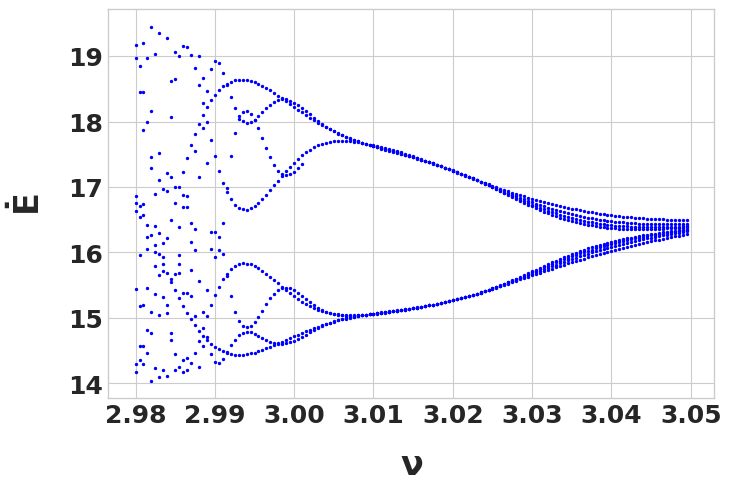

In [13]:
scale_factor = 100

for i in range(len(EEE)):
    plt.scatter(np.ones(len(EEE[i][0][0]))*EEE[i][1]*scale_factor,EEE[i][0],color='blue',s=2)

plt.xlabel(r'$\mathbf{\nu}$',fontsize=24, fontweight='bold',labelpad=15)
plt.ylabel(r"$\mathbf{\dot E}$",fontsize=24, fontweight='bold',labelpad=15)

plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(fontsize=18,fontweight='bold')


#xmin, xmax = plt.xlim()
#plt.xlim(xmin * scale_factor, xmax * scale_factor)

plt.savefig('KSbifurcation.png')

In [7]:
with open('results', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(EEE)